# Geoperception 数据集分析

本笔记本分析 Geoperception 数据集，这是一个用于评估多模态大语言模型在二维几何领域低级视觉感知能力的基准数据集。

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import sys
import seaborn as sns
from collections import Counter
import io

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 加载 Geoperception 数据集
data_path = '/Users/jia/datasets/Geoperception/data/train-00000-of-00001.parquet'

print(f"正在加载数据集: {data_path}")
table = pq.read_table(data_path)
df = table.to_pandas()

print(f"数据集形状: {df.shape}")
print(f"列名: {list(df.columns)}")

正在加载数据集: /Users/jia/datasets/Geoperception/data/train-00000-of-00001.parquet
数据集形状: (11657, 5)
列名: ['id', 'question', 'answer', 'predicate', 'image']


In [ ]:
# 检查所有image数据的键
all_keys = set()
for idx, row in df.iterrows():
    img_data = row['image']
    if isinstance(img_data, dict):
        all_keys.update(img_data.keys())
    else:
        print(f"第{idx}行不是字典类型: {type(img_data)}")
    
    if idx < 10:  # 只检查前10行来查看结构
        print(f"第{idx}行image键: {list(img_data.keys()) if isinstance(img_data, dict) else 'N/A'}")

print(f"\n所有发现的键: {all_keys}")

# 检查是否有其他键除了'bytes'
other_keys = all_keys - {'bytes'}
if other_keys:
    print(f"\n除了'bytes'外还发现的键: {other_keys}")
    
    # 统计每种键出现的频率
    key_counts = {}
    for key in all_keys:
        key_counts[key] = 0
    
    for idx, row in df.iterrows():
        img_data = row['image']
        if isinstance(img_data, dict):
            for key in img_data.keys():
                key_counts[key] += 1
    
    print("\n各键出现次数:")
    for key, count in key_counts.items():
        print(f"  {key}: {count} 次")
else:
    print("\n只有'bytes'键存在")

# 检查image数据的前几个字节以确认是PNG格式
print(f"\n检查PNG文件头:")
for i in range(3):
    img_data = df.iloc[i]['image']
    if isinstance(img_data, dict) and 'bytes' in img_data:
        img_bytes = img_data['bytes']
        # PNG文件头是\x89PNG\r\n\x1a\n
        header = img_bytes[:16]
        print(f"第{i}行PNG头: {header[:8]}... (长度: {len(img_bytes)})")
    else:
        print(f"第{i}行不是预期格式")

第0行image键: ['bytes', 'path']
第1行image键: ['bytes', 'path']
第2行image键: ['bytes', 'path']
第3行image键: ['bytes', 'path']
第4行image键: ['bytes', 'path']
第5行image键: ['bytes', 'path']
第6行image键: ['bytes', 'path']
第7行image键: ['bytes', 'path']
第8行image键: ['bytes', 'path']
第9行image键: ['bytes', 'path']

所有发现的键: {'path', 'bytes'}

除了'bytes'外还发现的键: {'path'}

各键出现次数:
  path: 11657 次
  bytes: 11657 次

检查PNG文件头:
第0行PNG头: b'\x89PNG\r\n\x1a\n'... (长度: 41690)
第1行PNG头: b'\x89PNG\r\n\x1a\n'... (长度: 41690)
第2行PNG头: b'\x89PNG\r\n\x1a\n'... (长度: 8301)


In [3]:
# 显示数据集的基本信息
print("数据集基本信息:")
print(df.info())

print("\n前5行数据:")
print(df.head())

数据集基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         11657 non-null  object
 1   question   11657 non-null  object
 2   answer     11657 non-null  object
 3   predicate  11657 non-null  object
 4   image      11657 non-null  object
dtypes: object(5)
memory usage: 455.5+ KB
None

前5行数据:
           id                                          question      answer  \
0  0000000005               What is the point lying on line UR?           S   
1  0000000006  What is the point lying on circle with center R?  T, V, S, U   
2  0000000007               What is the point lying on line BA?           E   
3  0000000018               What is the point lying on line GA?           D   
4  0000000080               What is the point lying on line EA?  F, G, B, D   

           predicate                                              image  
0    P

数据集统计信息:
总样本数: 11657
问题类型分布:
predicate
Equals                 4436
AngleClassification    2193
PointLiesOnLine        1901
LineComparison         1394
Perpendicular          1268
PointLiesOnCircle       359
Parallel                106
Name: count, dtype: int64


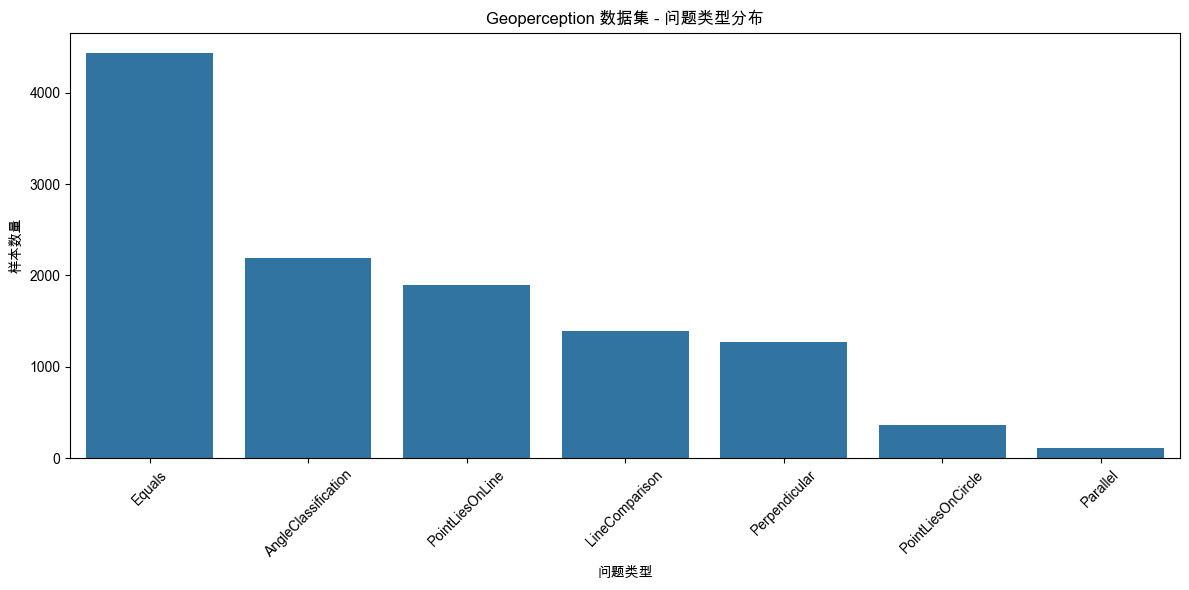

In [4]:
# 检查数据集的统计信息
print("数据集统计信息:")
print(f"总样本数: {len(df)}")
print(f"问题类型分布:")
predicate_counts = df['predicate'].value_counts()
print(predicate_counts)

# 可视化问题类型分布
plt.figure(figsize=(12, 6))
sns.barplot(x=predicate_counts.index, y=predicate_counts.values)
plt.title('Geoperception 数据集 - 问题类型分布')
plt.xlabel('问题类型')
plt.ylabel('样本数量')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

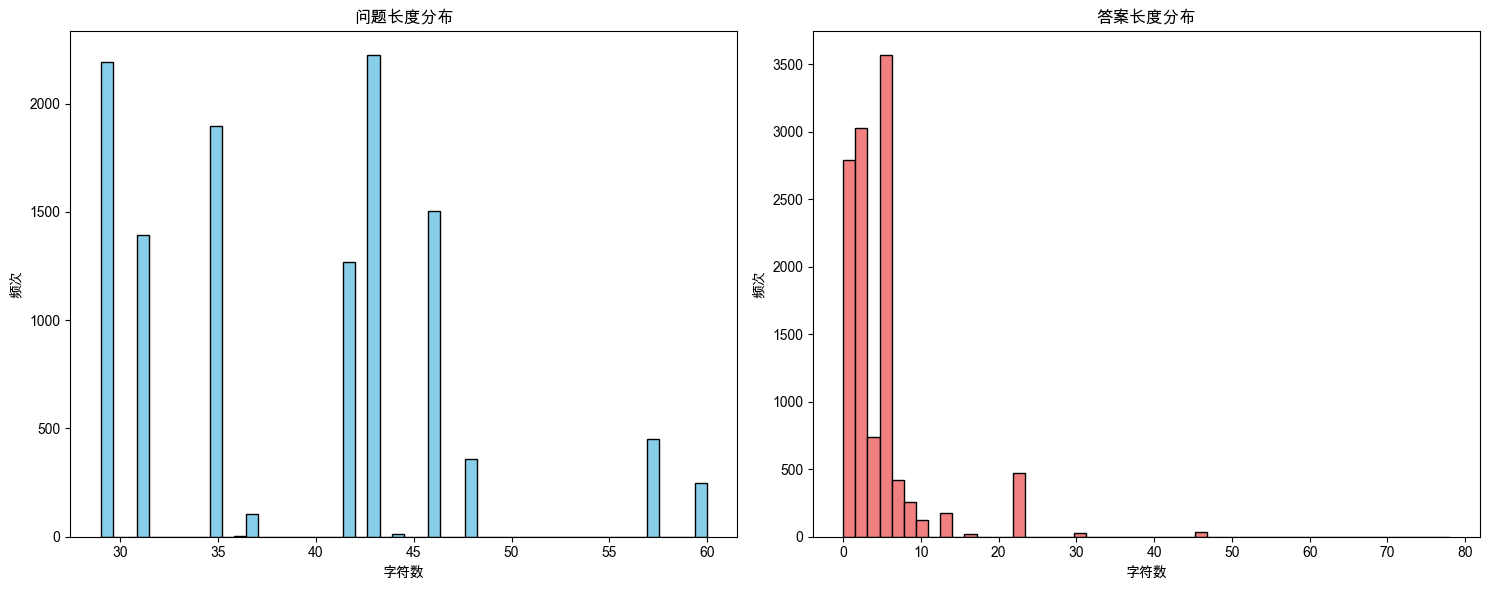

平均问题长度: 38.91 字符
平均答案长度: 4.62 字符


In [5]:
# 分析问题和答案长度分布
df['question_length'] = df['question'].apply(len)
df['answer_length'] = df['answer'].apply(len)

# 绘制问题和答案长度分布
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].hist(df['question_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('问题长度分布')
axes[0].set_xlabel('字符数')
axes[0].set_ylabel('频次')

axes[1].hist(df['answer_length'], bins=50, color='lightcoral', edgecolor='black')
axes[1].set_title('答案长度分布')
axes[1].set_xlabel('字符数')
axes[1].set_ylabel('频次')

plt.tight_layout()
plt.show()

print(f"平均问题长度: {df['question_length'].mean():.2f} 字符")
print(f"平均答案长度: {df['answer_length'].mean():.2f} 字符")

In [6]:
# 随机采样并显示一些样本
sample_size = 5
sample_df = df.sample(n=sample_size, random_state=42)

print(f"随机采样 {sample_size} 个样本:")
for idx, row in sample_df.iterrows():
    print(f"\n样本 {idx+1}:")
    print(f"ID: {row['id']}")
    print(f"问题类型: {row['predicate']}")
    print(f"问题: {row['question']}")
    print(f"答案: {row['answer']}")
    print(f"图像类型: {type(row['image'])}")
    
    # 尝试检查图像信息
    if hasattr(row['image'], 'size'):
        print(f"图像尺寸: {row['image'].size}")
    elif isinstance(row['image'], bytes):
        print(f"图像字节长度: {len(row['image'])}")
    elif isinstance(row['image'], str):
        print(f"图像路径/URL: {row['image']}")
    print("-" * 50)

随机采样 5 个样本:

样本 3859:
ID: 0000007379
问题类型: Perpendicular
问题: What is the line perpendicular to line BM?
答案: YX, YM, XY, XM, MY, MX
图像类型: <class 'dict'>
--------------------------------------------------

样本 5688:
ID: 0000015800
问题类型: Equals
问题: What is the measure of angle DCF as annotated?
答案: 54
图像类型: <class 'dict'>
--------------------------------------------------

样本 8519:
ID: 0000100448
问题类型: AngleClassification
问题: Is angle AFD acute or obtuse?
答案: obtuse
图像类型: <class 'dict'>
--------------------------------------------------

样本 11301:
ID: 0000103230
问题类型: AngleClassification
问题: Is angle RTZ acute or obtuse?
答案: obtuse
图像类型: <class 'dict'>
--------------------------------------------------

样本 11624:
ID: 0000103553
问题类型: AngleClassification
问题: Is angle BCD acute or obtuse?
答案: obtuse
图像类型: <class 'dict'>
--------------------------------------------------


图像列的数据类型: <class 'dict'>
图像模式: RGBA
图像尺寸: (512, 469)


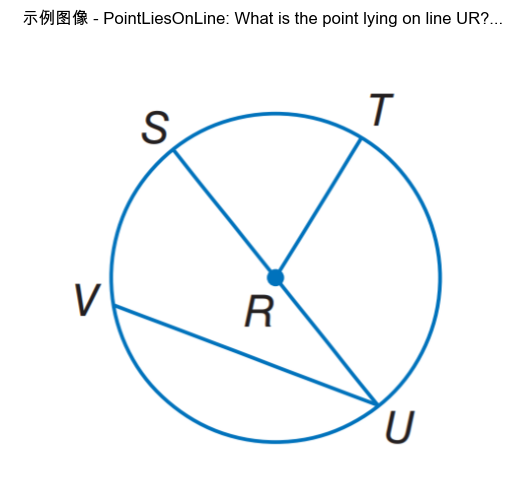

In [9]:
# 尝试显示部分图像样本
# 检查图像数据格式
first_row = df.iloc[0]
print(f"图像列的数据类型: {type(first_row['image'])}")

# 图像数据是字典格式，包含'bytes'键
if isinstance(first_row['image'], dict) and 'bytes' in first_row['image']:
    try:
        image_bytes = first_row['image']['bytes']
        image = Image.open(io.BytesIO(image_bytes))
        print(f"图像模式: {image.mode}")
        print(f"图像尺寸: {image.size}")
        
        # 显示图像
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f"示例图像 - {first_row['predicate']}: {first_row['question'][:50]}...")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"图像处理错误: {e}")
else:
    print("无法确定图像数据格式")

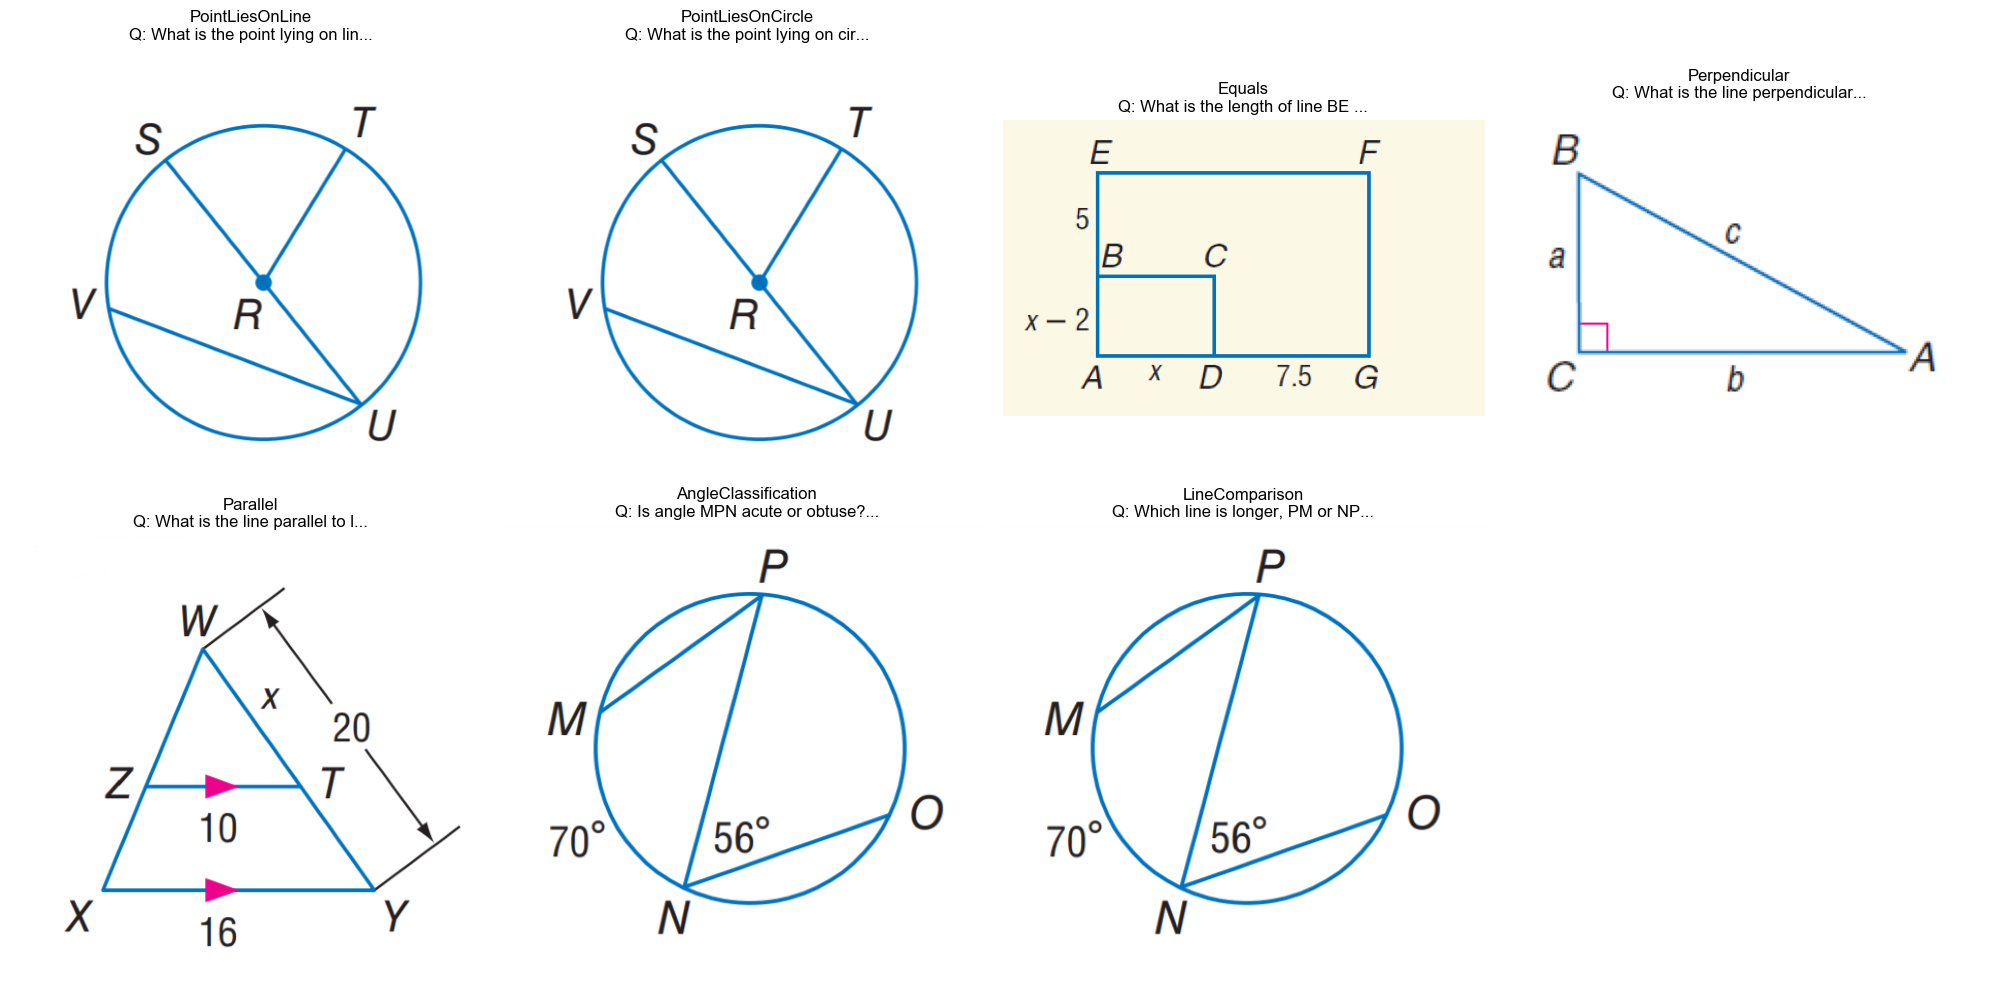

In [10]:
# 为每种问题类型显示一个样本图像
unique_predicates = df['predicate'].unique()
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, predicate in enumerate(unique_predicates[:8]):  # 最多显示8种类型
    predicate_sample = df[df['predicate'] == predicate].iloc[0]
    
    # 检查是否有图像数据 - 现在是字典格式
    if isinstance(predicate_sample['image'], dict) and 'bytes' in predicate_sample['image']:
        try:
            img_bytes = predicate_sample['image']['bytes']
            img = Image.open(io.BytesIO(img_bytes))
            axes[i].imshow(img)
            axes[i].set_title(f'{predicate}\nQ: {predicate_sample["question"][:30]}...')
            axes[i].axis('off')
        except Exception as e:
            axes[i].text(0.5, 0.5, f'图像加载失败:\n{str(e)}', 
                         horizontalalignment='center', verticalalignment='center',
                         transform=axes[i].transAxes, fontsize=12)
            axes[i].set_title(f'{predicate} (图像加载失败)')
            axes[i].axis('off')
    else:
        axes[i].text(0.5, 0.5, f'无法加载图像', 
                     horizontalalignment='center', verticalalignment='center',
                     transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f'{predicate} (图像格式未知)')
        axes[i].axis('off')

# 隐藏多余的子图
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

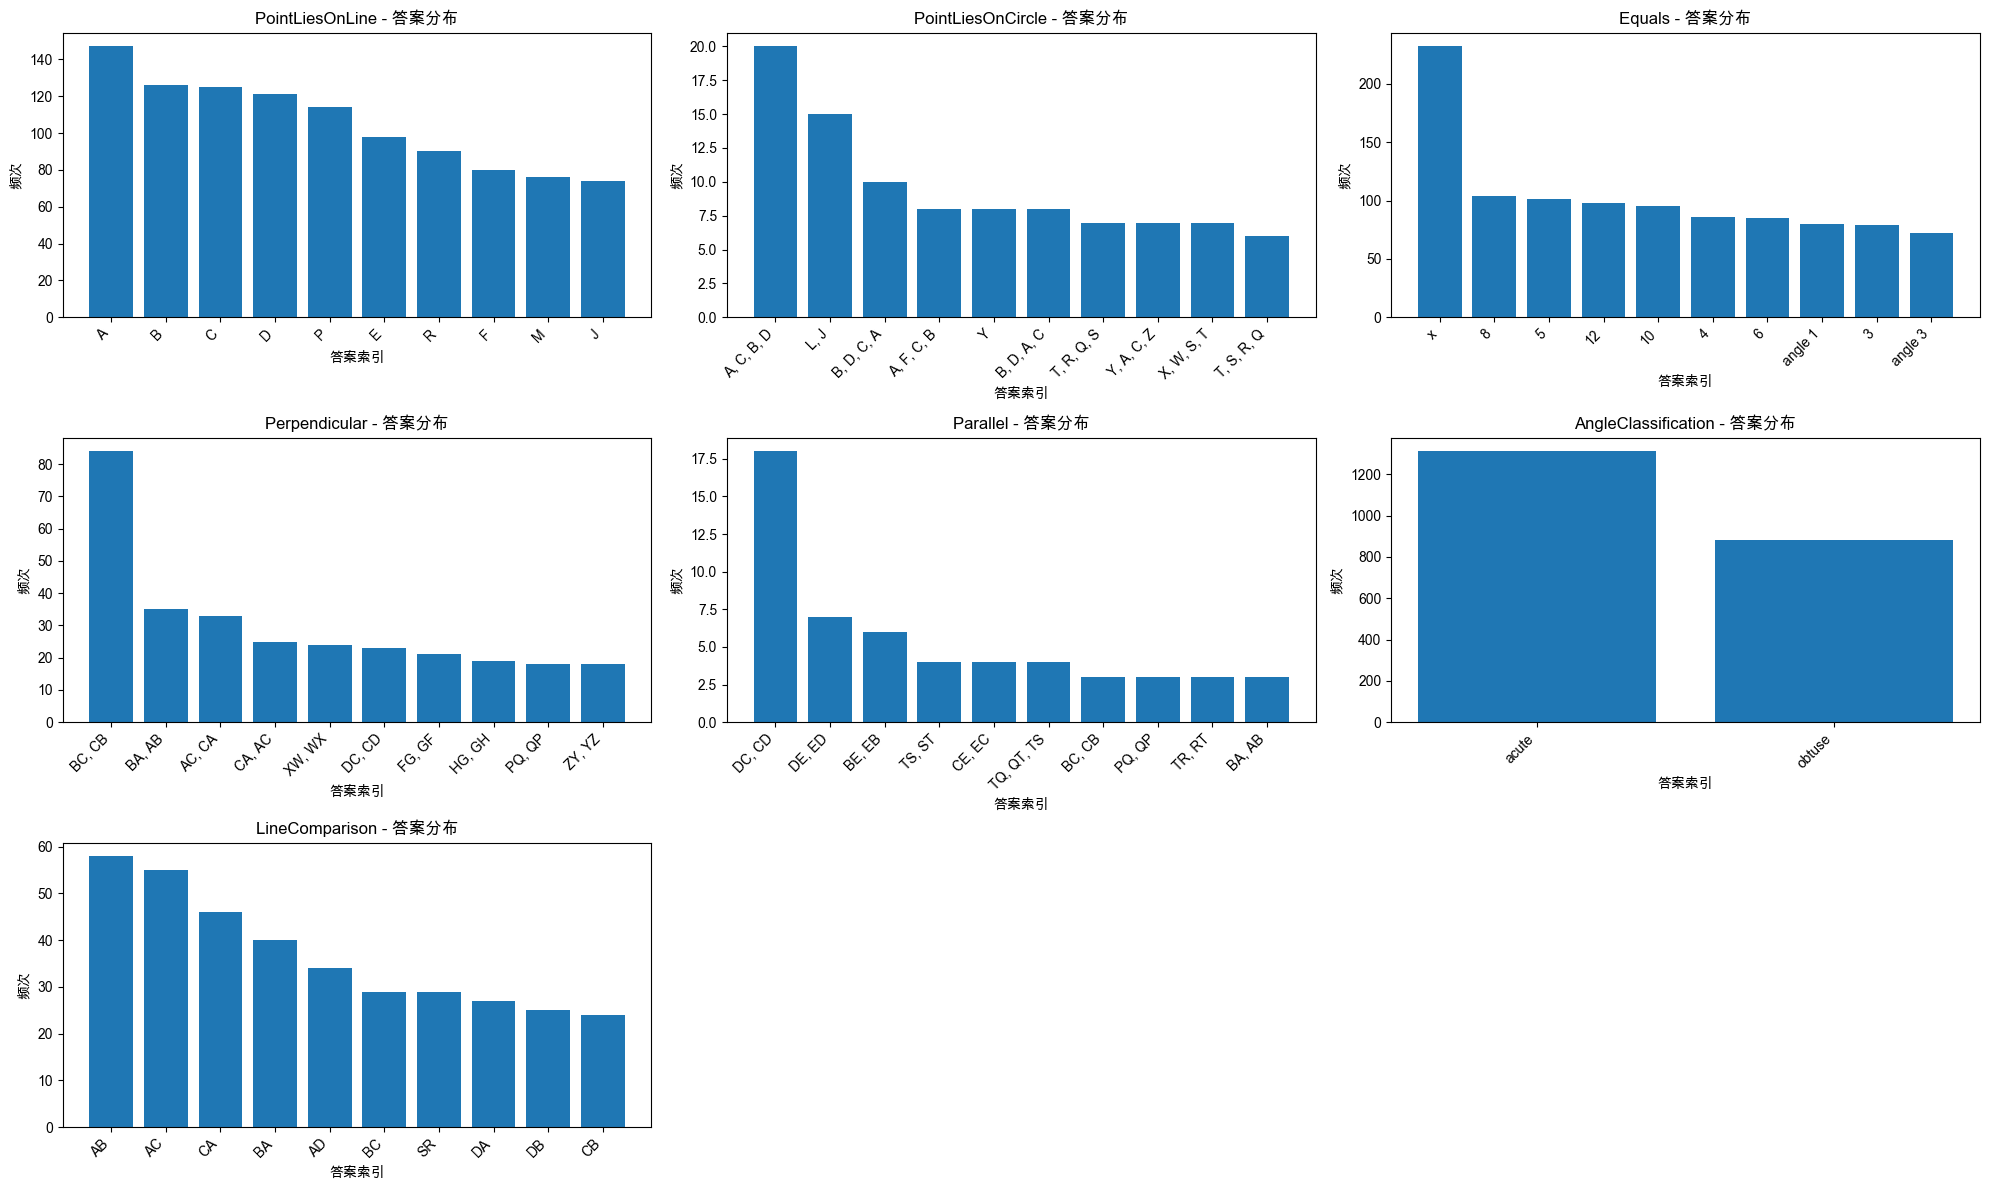

In [11]:
# 分析不同问题类型的答案分布
plt.figure(figsize=(20, 12))

# 为每个问题类型计算答案的最常见值
for i, predicate in enumerate(df['predicate'].unique()[:7]):  # 只显示前7个类型
    plt.subplot(3, 3, i+1)
    
    predicate_answers = df[df['predicate'] == predicate]['answer']
    answer_counts = predicate_answers.value_counts().head(10)  # 取前10个最常见的答案
    
    plt.bar(range(len(answer_counts)), answer_counts.values)
    plt.title(f'{predicate} - 答案分布')
    plt.xlabel('答案索引')
    plt.ylabel('频次')
    plt.xticks(range(len(answer_counts)), 
               [ans[:10] for ans in answer_counts.index], 
               rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [12]:
# 统计数据集中的各种问题类型和其对应的答案特点
print("各问题类型统计:")
for predicate in df['predicate'].unique():
    predicate_data = df[df['predicate'] == predicate]
    print(f"\n{predicate}:")
    print(f"  样本数量: {len(predicate_data)}")
    print(f"  平均问题长度: {predicate_data['question_length'].mean():.2f}")
    print(f"  平均答案长度: {predicate_data['answer_length'].mean():.2f}")
    
    # 显示最常见的答案
    top_answers = predicate_data['answer'].value_counts().head(3)
    print(f"  最常见答案:")
    for ans, count in top_answers.items():
        print(f"    '{ans}' - {count} 次")

各问题类型统计:

PointLiesOnLine:
  样本数量: 1901
  平均问题长度: 35.00
  平均答案长度: 1.24
  最常见答案:
    'A' - 147 次
    'B' - 126 次
    'C' - 125 次

PointLiesOnCircle:
  样本数量: 359
  平均问题长度: 48.00
  平均答案长度: 8.36
  最常见答案:
    'A, C, B, D, E' - 20 次
    'L, J' - 15 次
    'B, D, C, A' - 10 次

Equals:
  样本数量: 4436
  平均问题长度: 46.39
  平均答案长度: 3.50
  最常见答案:
    'x' - 232 次
    '8' - 104 次
    '5' - 101 次

Perpendicular:
  样本数量: 1268
  平均问题长度: 42.00
  平均答案长度: 13.79
  最常见答案:
    'BC, CB' - 84 次
    'BA, AB' - 35 次
    'AC, CA' - 33 次

Parallel:
  样本数量: 106
  平均问题长度: 37.00
  平均答案长度: 8.49
  最常见答案:
    'DC, CD' - 18 次
    'DE, ED' - 7 次
    'BE, EB' - 6 次

AngleClassification:
  样本数量: 2193
  平均问题长度: 29.00
  平均答案长度: 5.40
  最常见答案:
    'acute' - 1311 次
    'obtuse' - 882 次

LineComparison:
  样本数量: 1394
  平均问题长度: 31.00
  平均答案长度: 2.00
  最常见答案:
    'AB' - 58 次
    'AC' - 55 次
    'CA' - 46 次


In [13]:
# 保存采样数据的摘要
summary_path = '/Users/jia/workspace/math-data/notebooks/geoperception_summary.txt'
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(f"Geoperception 数据集摘要\n")
    f.write(f"总样本数: {len(df)}\n")
    f.write(f"列数: {len(df.columns)}\n")
    f.write(f"问题类型: {list(df['predicate'].unique())}\n")
    f.write(f"\n问题类型分布:\n")
    for predicate, count in predicate_counts.items():
        f.write(f"  {predicate}: {count} ({count/len(df)*100:.2f}%)\n")
    
    f.write(f"\n平均问题长度: {df['question_length'].mean():.2f} 字符\n")
    f.write(f"平均答案长度: {df['answer_length'].mean():.2f} 字符\n")

print(f"摘要已保存到: {summary_path}")

摘要已保存到: /Users/jia/workspace/math-data/notebooks/geoperception_summary.txt
